In [129]:
import classification_utils
import unet_utils
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import segmentation_models as sm
from tensorflow import keras
import os
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve,precision_recall_curve,auc
from joblib import load
from dtreeviz.trees import dtreeviz
from sklearn import tree
from sklearn.metrics import roc_curve,precision_recall_curve,auc

path = '/hpf/largeprojects/tabori/users/yuan/lmp1210/data/classification/'
WRITE=False

In [130]:
#load UNet model
sm.set_framework('tf.keras')
sm.framework()
#define model
BACKBONE = 'vgg19'
CLASSES = ['NCI', 'GCI','_background_']
preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, encoder_weights=None,classes=3, activation='softmax',input_shape=(None, None, 3),encoder_freeze=True)
model.load_weights('tuning_model_000_newbase.h5')

In [131]:
#load test data
def predictFig(path):
    imgs = classification_utils.crop_image(path)
    imgs = preprocess_input(imgs)
    pr_all = model.predict_on_batch(imgs)
    pr_all_raw = pr_all
    pr_all = unet_utils.threshold(pr_all,0.99,0.99)
    return pr_all, pr_all_raw

def load_test(path,N):
    sample_name=[]
    NCI_pixels=[]
    GCI_pixels=[]
    NCI_prob_sum=[]
    GCI_prob_sum=[]
    total_pixels=[]
    tags = ['LBD_SN','LBD_CWM','MSA_SN','MSA_CWM']
    for j in tags:
        #we have #11-#70 as training data
        for i in range(1,(N+1)):
            pr_all,pr_all_raw = predictFig(os.path.join(path,'test',j,f'{j}_{i}.tif'))
            NCI_pixels.append(np.count_nonzero(pr_all[...,0] == 1))
            GCI_pixels.append(np.count_nonzero(pr_all[...,1] == 1))
            NCI_prob_sum.append(np.sum(pr_all_raw[...,0]))
            GCI_prob_sum.append(np.sum(pr_all_raw[...,1]))
            total_pixels.append(pr_all.size)
            sample_name.append(f'{j}_{i}')
            print(f'finish for {j}_{i}')
    predictions = pd.DataFrame({'sample_name':sample_name,
                                'NCI_pixels':NCI_pixels,
                                'GCI_pixels':GCI_pixels,
                                'NCI_prob_sum':NCI_prob_sum,
                                'GCI_prob_sum':GCI_prob_sum,
                                'total_pixels':total_pixels})
    return predictions

if WRITE==True:   
    predictions = load_test(path,10)
    predictions.to_csv('classification_test.csv')
else:
    predictions=pd.read_csv('classification_test.csv')

In [132]:
#processing U-Net predction data for classification
features = pd.DataFrame({
    'sample_name':predictions.sample_name,
    'NCI_norm':predictions.NCI_pixels/predictions.total_pixels,
    'GCI_norm':predictions.GCI_pixels/predictions.total_pixels,
    'NCI_GCI_ratio':predictions.NCI_pixels/predictions.GCI_pixels,
    'NCI_prob_norm':predictions.NCI_prob_sum/predictions.total_pixels,
    'GCI_prob_norm':predictions.GCI_prob_sum/predictions.total_pixels,
    'NCI_GCI_prob_ratio':predictions.NCI_prob_sum/predictions.GCI_prob_sum,
                        }).fillna(0)
features.replace([np.inf, -np.inf], 99, inplace=True)

#shuffle match pair of the test data
# for i in range(0,10):
#     for j in range(10,20):
for i,j in zip(range(0,10),range(10,20)):
        if (i==0 and j==10):
            feature_LBD=np.expand_dims(np.append(features.iloc[i,1:],features.iloc[j,1:]),axis=0)
        else:
            feature_LBD=np.concatenate(
                (np.expand_dims(np.append(features.iloc[i,1:],features.iloc[j,1:]),axis=0),
                 feature_LBD)
            )            


# for i in range(20,30):
#     for j in range(30,40):
for i,j in zip(range(20,30),range(30,40)):
        if i==20 and j==30:
            feature_MSA=np.expand_dims(np.append(features.iloc[i,1:],features.iloc[j,1:]),axis=0)
        else:
            feature_MSA=np.concatenate(
                (np.expand_dims(np.append(features.iloc[i,1:],features.iloc[j,1:]),axis=0),
                 feature_MSA)
            )

features_test = np.concatenate((feature_LBD,feature_MSA))
np.shape(features_test)

(20, 12)

In [133]:
X_test = pd.DataFrame(
    {
         'NCI_norm_SN':features_test[:,0],
         'GCI_norm_SN':features_test[:,1],
         'NCI_GCI_ratio_SN':features_test[:,2],
#          'NCI_prob_norm_SN':features_test[:,3],
#          'GCI_prob_norm_SN':features_test[:,4],
#          'NCI_GCI_prob_ratio_SN':features_test[:,5],
         'NCI_norm_CWM':features_test[:,6],
         'GCI_norm_CWM':features_test[:,7],
         'NCI_GCI_ratio_CWM':features_test[:,8],
#          'NCI_prob_norm_CWM':features_test[:,9],
#          'GCI_prob_norm_CWM':features_test[:,10],
#          'NCI_GCI_prob_ratio_CWM':features_test[:,11]
    }
)
#normalize
X_test = (X_test-X_test.min())/(X_test.max()-X_test.min())
print(X_test)

y_test = (['LBD']*10+['MSA']*10)
#LBD=0, MSA=1
y_test = ([0]*10+[1]*10)

   NCI_norm_SN GCI_norm_SN NCI_GCI_ratio_SN NCI_norm_CWM GCI_norm_CWM  \
0        0.488    0.620435         0.349951          0.0          0.0   
1     0.612121    0.789501         0.372904          0.0          0.0   
2     0.344131    0.136587         0.500118          0.0          0.0   
3     0.552197    0.785463         0.337607          0.0          0.0   
4     0.508664    0.752282         0.320491     0.583333          0.0   
5     0.333847    0.023701         0.637571     0.666667     0.000111   
6     0.642113    0.272647         0.723837          0.0          0.0   
7     0.560549    0.277037         0.627441          0.0          0.0   
8     0.595828    0.728933          0.38366          0.0          0.0   
9          1.0    0.349895              1.0          0.0          0.0   
10    0.000546    0.838483         0.000241          0.0     0.621886   
11    0.000624    0.438904         0.000851          0.0     0.605427   
12         0.0    0.725421              0.0        

In [134]:
#load model 
dt = load('decision_tree.joblib')
lgr = load('logistic_regression.joblib')

In [135]:
y_dt = dt.predict(X_test)
y_lgr = lgr.predict(X_test)
y_dt_proba = dt.predict_proba(X_test)
y_lgr_proba = lgr.predict_proba(X_test)

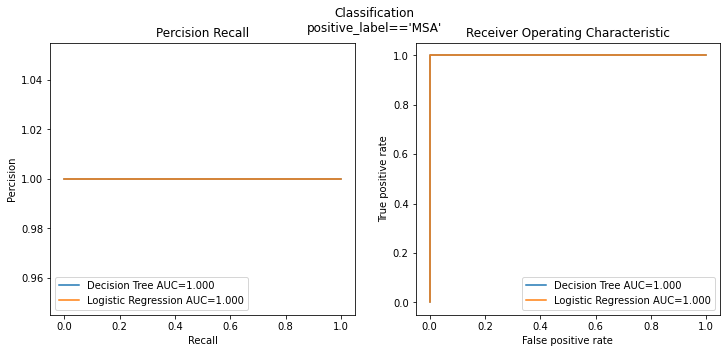

In [136]:
#ROC and PR curve
prcurve_dt = precision_recall_curve(y_test,y_dt_proba[:,1])
auc_pr_dt=auc(prcurve_dt[1],prcurve_dt[0])
prcurve_lgr = precision_recall_curve(y_test,y_lgr_proba[:,1])
auc_pr_lgr=auc(prcurve_lgr[1],prcurve_lgr[0])

roccurve_dt = roc_curve(y_test,y_dt_proba[:,1])
auc_roc_dt=auc(roccurve_dt[0],roccurve_dt[1])
roccurve_lgr = roc_curve(y_test,y_lgr_proba[:,1])
auc_roc_lgr=auc(roccurve_lgr[0],roccurve_lgr[1])

fig_curve,ax_curve = plt.subplots(figsize=(12,5))
ax_pr = plt.subplot(121)
plt.plot(prcurve_dt[1],prcurve_dt[0],label=f'Decision Tree AUC={auc_pr_dt:.3f}')
plt.plot(prcurve_lgr[1],prcurve_lgr[0],label=f'Logistic Regression AUC={auc_pr_lgr:.3f}')
plt.title('Percision Recall')
plt.xlabel('Recall')
plt.ylabel('Percision')
plt.legend(loc=3)
ax_roc = plt.subplot(122)
plt.plot(roccurve_dt[0],roccurve_dt[1],label=f'Decision Tree AUC={auc_roc_dt:.3f}')
plt.plot(roccurve_lgr[0],roccurve_lgr[1],label=f'Logistic Regression AUC={auc_roc_lgr:.3f}')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.suptitle('Classification\npositive_label==\'MSA\'')
fig_curve.savefig('classification-curve.png',dpi=500)

In [137]:
print(dt.score(X_test,y_test))
print(lgr.score(X_test,y_test))

1.0
1.0


In [138]:
y_lgr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])